In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
import sklearn

from tensorflow import keras
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score ,roc_auc_score , classification_report

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
df = pd.read_csv('BBC News Train.csv')
test_set = pd.read_csv('BBC News Test.csv')

In [3]:
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


# Data Visualization

<AxesSubplot:xlabel='Category', ylabel='count'>

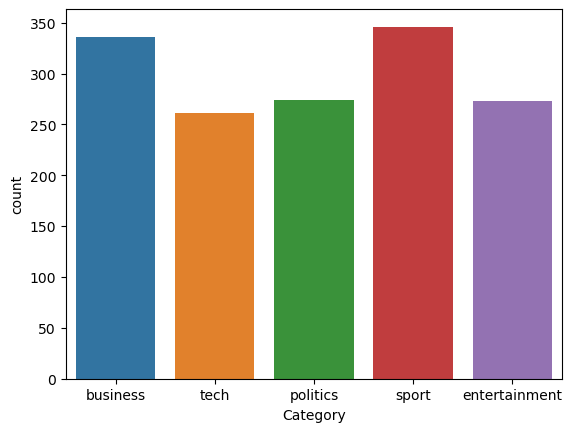

In [4]:
import seaborn as sns
sns.countplot(x='Category',data=df)

In [5]:
text = df['Text']
text.head()

0    worldcom ex-boss launches defence lawyers defe...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle  governs mobile choice  faster  bett...
4    enron bosses in $168m payout eighteen former e...
Name: Text, dtype: object

# Data Preprocessing

In [8]:
def preprocessDataset(train_text):
#     Word Tokeniztion using text-to-word-sequence
    train_text = str(train_text)
    tokenized_train_set = text_to_word_sequence(train_text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
    
#     stopword removal
    stop_words = set(stopwords.words('english'))
    stopwordremove = [i for i in tokenized_train_set if not i in stop_words]
    
#     join words into sentence
    stopwordremove_text = ' '.join(stopwordremove)
    
#     remove numbers
    numberremove_text = ''.join(c for c in stopwordremove_text if not c.isdigit())
    
#     Stemming
    stemmer = PorterStemmer()
    
    stem_input = nltk.word_tokenize(numberremove_text)
    stem_text = ' '.join([stemmer.stem(word) for word in stem_input])
    
    lemmatizer = WordNetLemmatizer()
    def get_wordnet_pos(word):

        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    lem_input = nltk.word_tokenize(stem_text)
    lem_text= ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])
        
    return lem_text

In [10]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aakas\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [11]:
df['Text'] = df['Text'].apply(preprocessDataset)
text = df['Text']
category = df['Category']
text.head()

0    worldcom ex bos launch defenc lawyer defend fo...
1    german busi confid slide german busi confid fe...
2    bbc poll indic econom gloom citizen major nati...
3    lifestyl govern mobil choic faster well funkie...
4    enron bos m payout eighteen former enron direc...
Name: Text, dtype: object

In [12]:
X_train, X_test, y_train, y_test = train_test_split(text,category, test_size=0.3,shuffle=True,random_state=60,stratify=category)

In [13]:
print(len(X_train))
print(len(X_test))

1043
447


In [14]:
X_train

958     broadband uk grow fast high speed net connect ...
43      viewer abl shape tv imagin edit titan watch fa...
141     verizon seal takeov mci verizon takeov battl u...
421     bet big brother leak bookmak stop take bet cel...
1004    ferguson put faith youngster manchest unit man...
                              ...                        
1138    mix signal french economi french economi pick ...
516     safin cool wimbledon newli crown australian op...
339     u duo first spam convict brother sister u conv...
336     mcconnel detail scot wave toll least three peo...
668     nadal march mexico rafael nadal continu run fi...
Name: Text, Length: 1043, dtype: object

In [15]:
y_test

1073             tech
1062             tech
122             sport
487          business
1236    entertainment
            ...      
765     entertainment
186          business
1292    entertainment
1044         politics
1190             tech
Name: Category, Length: 447, dtype: object

# Multinomial Naive Bayes

In [16]:
nb = Pipeline([('tfidf',TfidfVectorizer()),
              ('clf',MultinomialNB()),
              ])
nb.fit(X_train,y_train)

test_predict = nb.predict(X_test)

train_accuracy = round(nb.score(X_train,y_train)*100)
test_accuracy =round(accuracy_score(test_predict,y_test)*100)

print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
print()

Naive Bayes Train Accuracy Score : 99% 
Naive Bayes Test Accuracy Score  : 96% 



In [17]:
target_category = df['Category'].unique()
print(classification_report(test_predict, y_test, target_names=target_category))

               precision    recall  f1-score   support

     business       0.98      0.94      0.96       105
         tech       0.93      1.00      0.96        76
     politics       0.93      0.94      0.93        81
        sport       1.00      0.98      0.99       106
entertainment       0.96      0.95      0.96        79

     accuracy                           0.96       447
    macro avg       0.96      0.96      0.96       447
 weighted avg       0.96      0.96      0.96       447



# Pickle File

In [68]:
import pickle
filename = 'news article.pkl'
pickle.dump(nb, open(filename, 'wb'))

In [18]:
test_set['Text'] = test_set['Text'].apply(preprocessDataset)

test_id = test_set['ArticleId']
test_text = test_set['Text']
y_prdict = nb.predict(test_text)

In [19]:
y_prdict

array(['sport', 'tech', 'sport', 'business', 'sport', 'sport', 'politics',
       'politics', 'entertainment', 'business', 'business', 'tech',
       'politics', 'tech', 'entertainment', 'sport', 'politics', 'tech',
       'entertainment', 'politics', 'business', 'politics', 'sport',
       'business', 'politics', 'sport', 'business', 'sport', 'sport',
       'business', 'politics', 'tech', 'business', 'business', 'sport',
       'sport', 'sport', 'business', 'entertainment', 'politics', 'tech',
       'politics', 'entertainment', 'tech', 'sport', 'tech',
       'entertainment', 'business', 'politics', 'business', 'politics',
       'business', 'business', 'business', 'tech', 'politics', 'tech',
       'entertainment', 'sport', 'tech', 'sport', 'entertainment', 'tech',
       'politics', 'business', 'entertainment', 'sport', 'tech', 'sport',
       'sport', 'tech', 'sport', 'business', 'politics', 'tech', 'sport',
       'tech', 'tech', 'tech', 'entertainment', 'politics', 'sport',
   

In [20]:
#submission = pd.DataFrame(test_id)
submission = pd.DataFrame(list(zip(test_id, y_prdict)),
               columns =['ArticleId', 'Category'])
submission.head(20)

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,entertainment
9,397,business


In [21]:
submission.to_csv('submission.csv', index=False)
